# Лабораторна робота №4. Дослiдження окремих блокiв та шарiв згорткових нейронних мереж

**Виконала** студентка групи КІ-51мп Додонова Марія

**Мета:** Навчитись використовувати та реалiзовувати спецiалiзованi блоки та шари для полiпшення архiтектур згорткових нейронних мереж. Дослiдити, як цi блоки впливають на точнiсть та ефективнiсть моделей, розроблених у попереднiх лабораторних роботах.

## Порядок виконання

1. Обрати одну з архiтектур, реалiзованих у лабораторнiй роботi №2 або №3 (наприклад, вашу власну просту CNN, VGG або ResNet), яка буде слугувати базовою моделлю для експериментiв. Використовуйте той самий датасет (Fashion MNIST, CIFAR-10) та пiдготовку даних.

2. Обрати 2-3 рiзних блоки (шари) для модифiкацiї обраної архiтектури зi списку:
* Squeeze-and-Excitation
* Attention (наприклад, CBAM)
* Dilated convolution
* Inception block
* Pointwise Convolution
* Будь-який iнший варiант зi списку.

3. Реалiзувати кожен обраний блок на вашому фреймворцi та iнтегрувати його в базову архiтектуру. Аргументуйте вибiр мiсця для iнтеграцiї (наприклад, "SE-блок додано пiсля кожного згорткового шару для калiбрування каналiв"). Ви повиннi отримати 2-3 модифiкованi архiтектури.

4. Навчити базову (якщо вона ще не навчена) та всi модифiкованi мережi на обраному датасетi. Слiдкуйте за тим, щоб умови навчання (кiлькiсть епох, оптимiзатор, швидкiсть навчання) були однаковими для коректного порiвняння.

5. Проаналiзувати результати. Порiвняйте графiки навчання та фiнальнi метрики (точнiсть, функцiя втрат) для всiх моделей. Оцiнiть, як доданi блоки вплинули на точнiсть, швидкiсть збiжностi та час навчання.

## Виконання роботи

### 1. Обрати одну з архiтектур, реалiзованих у лабораторнiй роботi №2 або №3 (наприклад, вашу власну просту CNN, VGG або ResNet), яка буде слугувати базовою моделлю для експериментiв. Використовуйте той самий датасет (Fashion MNIST, CIFAR-10) та пiдготовку даних.

### 2. Обрати 2-3 рiзних блоки (шари) для модифiкацiї обраної архiтектури зi списку:
* Squeeze-and-Excitation
* Attention (наприклад, CBAM)
* Dilated convolution
* Inception block
* Pointwise Convolution
* Будь-який iнший варiант зi списку.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

from src.models.vggnet import VGGNet, VGGNetSE, VGGNetCBAM
from src.trainer import Trainer
from src.plot_tools import plot_history

DATA_PATH = "data"
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
NUM_EPOCHS = 10
BATCH_SIZE = 128
LEARNING_RATE = 0.001
REDUCTION = 16

print(f"Using device: {DEVICE}")

Using device: cuda


In [2]:
transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)) # mean=0.5 and std=0.5
])

# Load train split
train_dataset = datasets.FashionMNIST(
    root=DATA_PATH,
    train=True,
    download=True,
    transform=transform
)

# Load test split
test_dataset = datasets.FashionMNIST(
    root=DATA_PATH,
    train=False,
    download=True,
    transform=transform
)

# Split train into train and validation
train_dataset, val_dataset = random_split(train_dataset, [0.8, 0.2])

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, pin_memory=True, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, pin_memory=True)
test_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, pin_memory=True)

### 3. Реалiзувати кожен обраний блок на вашому фреймворцi та iнтегрувати його в базову архiтектуру. Аргументуйте вибiр мiсця для iнтеграцiї (наприклад, "SE-блок додано пiсля кожного згорткового шару для калiбрування каналiв"). Ви повиннi отримати 2-3 модифiкованi архiтектури.

### 4. Навчити базову (якщо вона ще не навчена) та всi модифiкованi мережi на обраному датасетi. Слiдкуйте за тим, щоб умови навчання (кiлькiсть епох, оптимiзатор, швидкiсть навчання) були однаковими для коректного порiвняння.

In [3]:
criterion = nn.CrossEntropyLoss()

print("Training base VGGNet:")
vgg_model = VGGNet()
vgg_optimizer = optim.Adam(vgg_model.parameters(), lr=LEARNING_RATE)
vgg_trainer = Trainer(vgg_model, vgg_optimizer, criterion, device=DEVICE)
vgg_history = vgg_trainer.train(NUM_EPOCHS, train_loader, val_loader)

print("\nTraining VGGNetSE:")
vgg_se_model = VGGNetSE(reduction=REDUCTION)
vgg_se_optimizer = optim.Adam(vgg_se_model.parameters(), lr=LEARNING_RATE)
vgg_se_trainer = Trainer(vgg_se_model, vgg_se_optimizer, criterion, device=DEVICE)
vgg_se_history = vgg_se_trainer.train(NUM_EPOCHS, train_loader, val_loader)

print("\nTraining VGGNetCBAM:")
vgg_cbam_model = VGGNetCBAM(reduction=REDUCTION)
vgg_cbam_optimizer = optim.Adam(vgg_cbam_model.parameters(), lr=LEARNING_RATE)
vgg_cbam_trainer = Trainer(vgg_cbam_model, vgg_cbam_optimizer, criterion, device=DEVICE)
vgg_cbam_history = vgg_cbam_trainer.train(NUM_EPOCHS, train_loader, val_loader)

print("\nFinished Training!")

Training base VGGNet:
Epoch [ 1/10]: Train Loss: 0.8981, Val Loss: 0.4142, Train Accuracy: 0.6416, Val Accuracy: 0.8478.
Epoch [ 2/10]: Train Loss: 0.3944, Val Loss: 0.3629, Train Accuracy: 0.8576, Val Accuracy: 0.8688.
Epoch [ 3/10]: Train Loss: 0.3247, Val Loss: 0.3143, Train Accuracy: 0.8859, Val Accuracy: 0.8861.
Epoch [ 4/10]: Train Loss: 0.2947, Val Loss: 0.3026, Train Accuracy: 0.8950, Val Accuracy: 0.8882.
Epoch [ 5/10]: Train Loss: 0.2596, Val Loss: 0.2833, Train Accuracy: 0.9075, Val Accuracy: 0.9032.
Epoch [ 6/10]: Train Loss: 0.2374, Val Loss: 0.2637, Train Accuracy: 0.9153, Val Accuracy: 0.9083.
Epoch [ 7/10]: Train Loss: 0.2236, Val Loss: 0.3025, Train Accuracy: 0.9194, Val Accuracy: 0.9074.
Epoch [ 8/10]: Train Loss: 0.2106, Val Loss: 0.2464, Train Accuracy: 0.9249, Val Accuracy: 0.9134.
Epoch [ 9/10]: Train Loss: 0.1894, Val Loss: 0.2562, Train Accuracy: 0.9317, Val Accuracy: 0.9116.
Epoch [10/10]: Train Loss: 0.1783, Val Loss: 0.2509, Train Accuracy: 0.9357, Val Accura

### 5. Проаналiзувати результати. Порiвняйте графiки навчання та фiнальнi метрики (точнiсть, функцiя втрат) для всiх моделей. Оцiнiть, як доданi блоки вплинули на точнiсть, швидкiсть збiжностi та час навчання.

Base VGGNet Curves


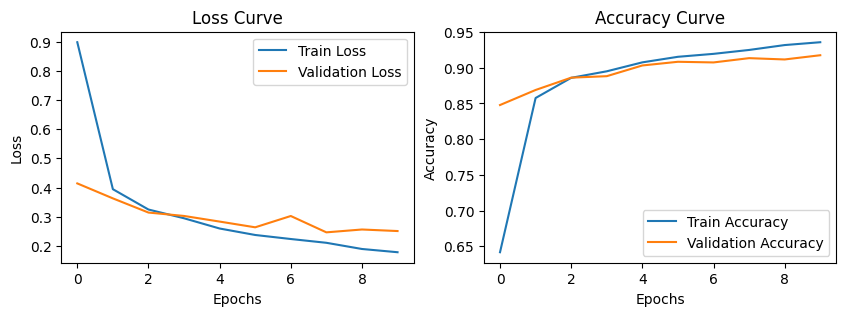

VGGNetSE Curves


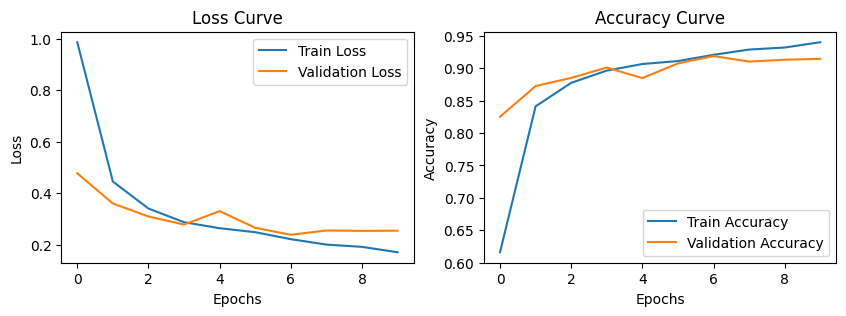

VGGNetCBAM Curves


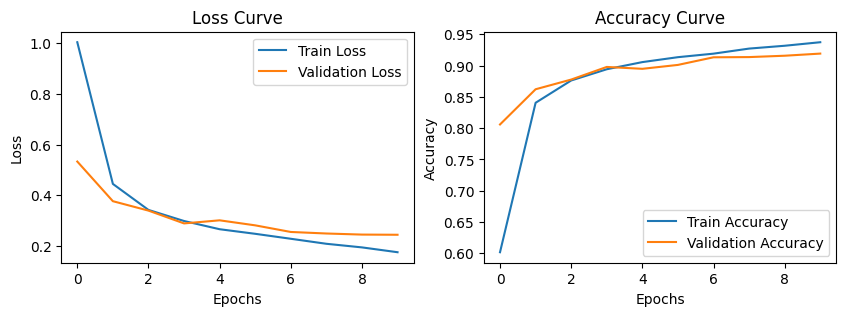

In [4]:
print("Base VGGNet Curves")
plot_history(vgg_history)

print("VGGNetSE Curves")
plot_history(vgg_se_history)

print("VGGNetCBAM Curves")
plot_history(vgg_cbam_history)

In [ ]:
print("VGGNet test results")
vgg_trainer.test(test_loader)

print("VGGNetSE test results")
vgg_se_trainer.test(test_loader)

print("VGGNetCBAM test results")
vgg_cbam_trainer.test(test_loader)

VGGNet test results
Loss: 0.2509 Accuracy: 0.9175
VGGNetSE test results
Loss: 0.2550 Accuracy: 0.9145
VGGNetCBAM test results
Loss: 0.2442 Accuracy: 0.9192


{'loss': [0.2442359726955282], 'accuracy': [0.9191666666666667]}

## Висновок